In [ ]:
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras import applications
from tensorflow.keras.models import Model
import os
import pathlib
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Loading Fer Data


In [ ]:
!unzip '/content/drive/My Drive/28577_36420_compressed_fer2013.csv.zip'

Archive:  /content/drive/My Drive/28577_36420_compressed_fer2013.csv.zip
  inflating: fer2013.csv             


### Load My Face Data

In [ ]:
directory = '/content/drive/My Drive/MyFace Dataset'

In [ ]:
myface_train = []
emotion_train = [] 
file_list = os.listdir(directory)
image = 0
for emotion_file in file_list:
    images_path_list = list(pathlib.Path(directory).glob(emotion_file+'/*.jpg'))
    for image_path in images_path_list: 
        image = np.array(Image.open(image_path).convert('L')).reshape(48,48,1)
        myface_train.append(image)
        emotion_train.append(emotion_file)
myface_train = np.array(myface_train)

### Reading fer dataset

In [ ]:
data = pd.read_csv('/content/fer2013.csv')

In [ ]:
train = data.drop('Usage',axis=1)

### Data Preprocessing

In [ ]:
def emotion_map(x):
  emotion_dict = {'Angry':0,'Disgust':1,'Fear':2,'Happy':3,'Sad':4,'Surprise':5,'Neutral':6}
  return emotion_dict[x]
emotion_train = list(map(lambda x:emotion_map(x),emotion_train))

In [ ]:
#Reshaping train data
X_train = np.array(list(train['pixels'].apply(lambda x:x.split())))
X_train = X_train.astype(int)
X_train = np.array(list(map(lambda x:x.reshape(48,48,1),X_train)))
Y_train = train['emotion']
#Adding MyFace data to it
X_train = np.array(list(X_train)+list(myface_train))
Y_train = list(Y_train)+emotion_train
#One Hot Encoding categorical output
Y_train = keras.utils.to_categorical(Y_train, 7)

In [ ]:
print('Train data shape:',X_train.shape)

Train data shape: (35942, 48, 48, 1)


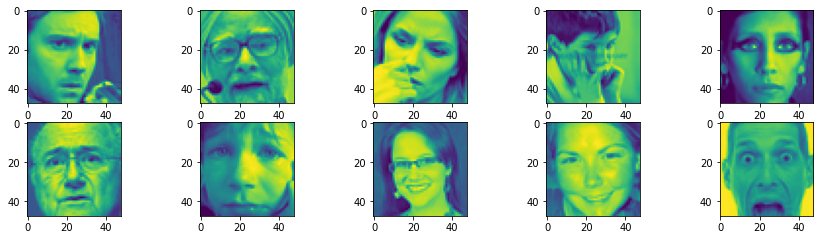

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i].reshape(48,48))

In [ ]:
train_gen = ImageDataGenerator(rescale=1/255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True,channel_shift_range=50,brightness_range=(1.2,1.2))
train_gen.fit(X_train)

In [ ]:
pre_trained_model = applications.VGG16(input_shape=(48,48,3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model = Model(pre_trained_model.input, x)
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
new_X_train = tensorflow.image.grayscale_to_rgb(tensorflow.constant(X_train)).numpy()

In [ ]:
training = model.fit(train_gen.flow(new_X_train,Y_train,batch_size=200),steps_per_epoch=150,epochs=10)

Epoch 1/10
150/150 [==============================] - 39s 261ms/step - loss: 0.5018 - accuracy: 0.8211
Epoch 2/10
150/150 [==============================] - 39s 260ms/step - loss: 0.4899 - accuracy: 0.8242
Epoch 3/10
150/150 [==============================] - 39s 261ms/step - loss: 0.4928 - accuracy: 0.8241
Epoch 4/10
150/150 [==============================] - 39s 262ms/step - loss: 0.4806 - accuracy: 0.8285
Epoch 5/10
150/150 [==============================] - 39s 259ms/step - loss: 0.4710 - accuracy: 0.8313
Epoch 6/10
150/150 [==============================] - 39s 260ms/step - loss: 0.4744 - accuracy: 0.8323
Epoch 7/10
150/150 [==============================] - 39s 259ms/step - loss: 0.4826 - accuracy: 0.8280
Epoch 8/10
150/150 [==============================] - 39s 260ms/step - loss: 0.4723 - accuracy: 0.8313
Epoch 9/10
150/150 [==============================] - 39s 261ms/step - loss: 0.4710 - accuracy: 0.8303
Epoch 10/10
150/150 [==============================] - 39s 259ms/step - l

In [ ]:
model.save_weights('fer_classifier_weights.h5')
with open('model_config.json','w') as json_file:
    json_file.write(model.to_json())

In [ ]:
def emotion_map(val):
  emotion = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
  onehot_dict = dict(zip(train['emotion'],Y_train))
  emotion_dict = {}
  output = 0
  for i in emotion:
    emotion_dict[i] = onehot_dict[emotion.index(i)]
  for i in emotion_dict:
    if (emotion_dict[i]==val).all():
      output = i
  return output

In [ ]:
onehot_dict = dict(zip(train['emotion'],Y_train))
onehot_dict

{0: array([1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 1: array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 2: array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 3: array([0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 4: array([0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 5: array([0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 6: array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)}

In [ ]:
def predict_image(image_arr):
  pred = np.round_(model.predict(image_arr.reshape(1,48,48,3)))
  print('Predicted Emotion:', emotion_map(pred))
  plt.rcParams['figure.figsize']=(3,3)
  plt.imshow(image_arr)

Predicted Emotion: Fear
Actual Emotion: Sad


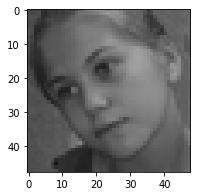

In [ ]:
index = 6 #Set the index of image and the respective prediction here to be displayed. 
predict_image(new_X_val[index])
print('Actual Emotion:',emotion_map(Y_val[index]))

In [ ]:
np.array([np.zeros((48,48))]*3).reshape(48,48,3).shape

(48, 48, 3)